In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import joblib

In [2]:
def load_data(data_dir):
    data = []
    labels = []
    for label, class_name in enumerate(['ripe', 'unripe']):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(class_dir, filename)
                csv_data = pd.read_csv(file_path).values.flatten()
                data.append(csv_data)
                labels.append(label)
    return np.array(data), np.array(labels)

In [3]:
data_dir = 'dataset'
data, labels = load_data(data_dir)
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
# Menyimpan scaler ke file
scaler_file = "scaler.pkl"
joblib.dump(scaler, scaler_file)
max_len = max(map(len, data))
data = np.array([np.pad(d, (0, max_len - len(d)), 'constant') for d in data])
len(data)

100

In [4]:
data = data.reshape((data.shape[0], data.shape[1], 1))
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# Initial split to get training + validation and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, train_size=0.7, stratify=labels)
# Secondary split to get training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val)

In [5]:
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(30, 1)),
    Conv1D(64, kernel_size=5, activation='relu'),
    Dropout(0.5),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 64)            384       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            20544     
                                                                 
 dropout (Dropout)           (None, 22, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 100)               70500     
                                                        

In [6]:
EPOCH = 100
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
3/3 [==============================] - 2s 221ms/step - loss: 0.7040 - accuracy: 0.4286 - val_loss: 0.6729 - val_accuracy: 0.4667
Epoch 2/100
3/3 [==============================] - 0s 46ms/step - loss: 0.6513 - accuracy: 0.5143 - val_loss: 0.6595 - val_accuracy: 0.4667
Epoch 3/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6293 - accuracy: 0.5286 - val_loss: 0.6452 - val_accuracy: 0.4667
Epoch 4/100
3/3 [==============================] - 0s 56ms/step - loss: 0.6120 - accuracy: 0.5857 - val_loss: 0.6323 - val_accuracy: 0.6000
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.5915 - accuracy: 0.6571 - val_loss: 0.6228 - val_accuracy: 0.6000
Epoch 6/100
3/3 [==============================] - 0s 65ms/step - loss: 0.5768 - accuracy: 0.6571 - val_loss: 0.6018 - val_accuracy: 0.6667
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 0.5467 - accuracy: 0.7000 - val_loss: 0.5717 - val_accuracy: 0.6667
Epoch 8/100
3/3 [==

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

1/1 [==============================] - 0s 29ms/step - loss: 0.2487 - accuracy: 0.9333
Test Accuracy: 93.33%


In [8]:
predictions = model.predict(X_test)
predictions = np.round(predictions,2).flatten()
predictions

1/1 [==============================] - 0s 238ms/step


array([0.93, 0.  , 0.98, 0.74, 0.  , 0.23, 0.94, 0.04, 0.92, 0.9 , 0.  ,
       0.  , 0.86, 0.91, 0.11], dtype=float32)

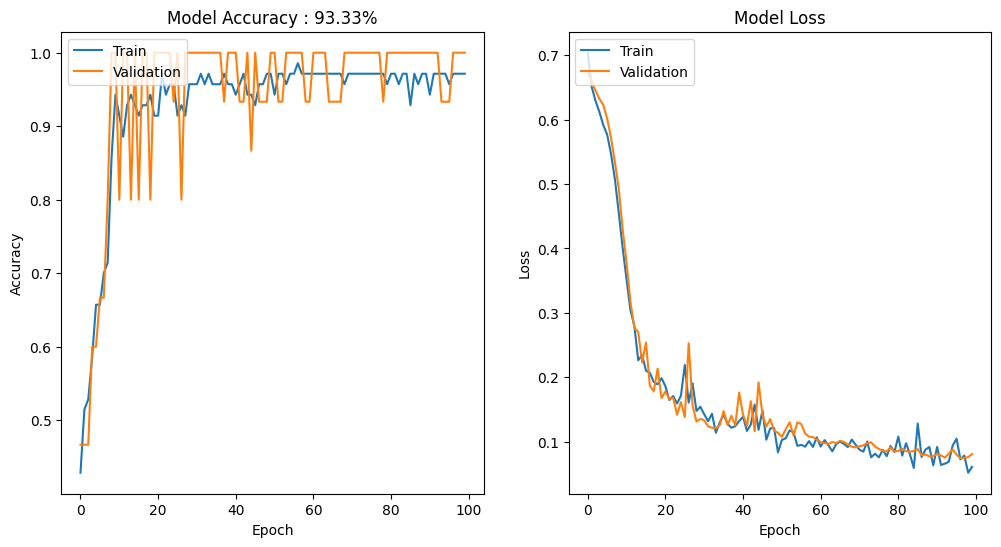

In [9]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Add validation accuracy
plt.title(f'Model Accuracy : {accuracy*100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

# Save the plot with the specified name format
plt.savefig(f"hasil training/excel/{date_time_str}.png")
plt.show()

1/1 [==============================] - 0s 28ms/step


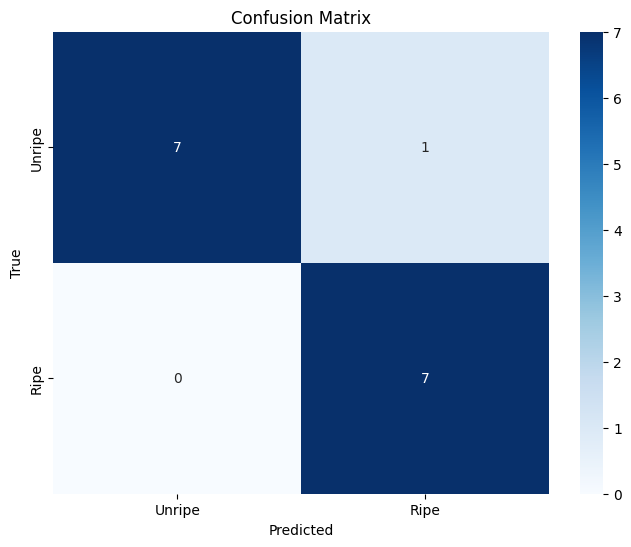

In [16]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.74).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
# Predicted Output vs Target
regular_float_arr = [[round(num[0], 2)] for num in y_pred]
predicted=[]
for num in regular_float_arr:
    predicted.append(num[0])


print(predicted)
print(y_test)

[0.93, 0.0, 0.98, 0.74, 0.0, 0.23, 0.94, 0.04, 0.92, 0.9, 0.0, 0.0, 0.86, 0.91, 0.11]
[1 0 1 1 0 0 1 0 0 1 0 0 1 1 0]


In [12]:
# save model to .tflite file
# now = datetime.datetime.now()
# # Format the date-time string as 'MMDDYYYY-HHMM'
# date_time_str = now.strftime("%d%m%Y-%H%M%S")
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# Save the TFLite model to a file
# with open(f'{date_time_str}.tflite', 'wb') as f:
#     f.write(tflite_model)

ROC and AUC to determine the most optimal threshold for Confussion Matrix \
Credit : https://www.youtube.com/watch?v=Joh3LOaG8Q0 (Dr. Sreenivas Bhattiprolu)

1/1 [==============================] - 0s 52ms/step


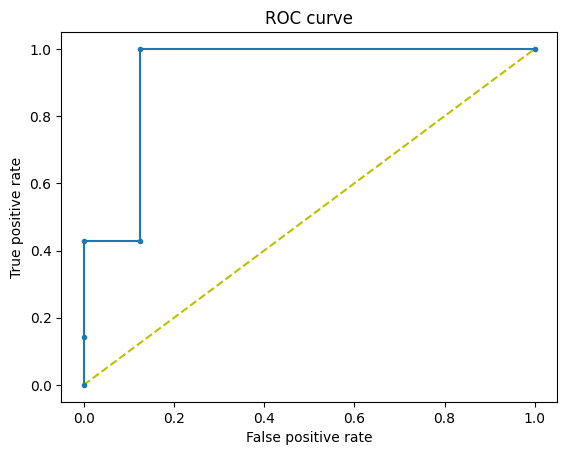

In [13]:
# Make predictions
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [14]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  4    0.74161
Name: thresholds, dtype: float32
